Lambda School Data Science

---

# Logistic Regression


## Assignment 🌯

Using a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/), build a model that predicts whether a burrito is rated `'Great'`?

## What We Want

*Associate Instructor* is a teaching position where you will work closely students — delivering curriculum, and leading question and answer sessions. The purpose of this assignment is to give us an idea of how you approach data science problems and whether you can explain that approach to someone who does not yet have your level of expertise. Given this, we are less interested you building a "perfect" model and more focused on how you use this assignment to teach important concepts to a data science student.

## What You Need to Do

- [ ] Make a copy of this notebook to work on - you can download if you have a local Jupyter setup, or click `File > Save a copy in Drive` to copy and work on with Google Colab
- [ ] Import the burrito `csv` file into a `DataFrame`. Your target will be the `'Great'` column.
- [ ] Conduct exploratory data analysis (EDA) to determine how you should clean the data for your pipeline.
- [ ] Clean your data. (Note: You are not required to use all columns in your model, but justify your decisions based on your EDA.)
- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Determine what the baseline accuracy is for a naïve classification model.
- [ ] Create a `scikit-learn` pipeline with the following components:
  - A one hot encoder for categorical features.
  - A scaler.
  - A logistic regressor.
- [ ] Train your model using the training data.
- [ ] Create a visualization showing your model's coefficients.
- [ ] Get your model's validation accuracy (multiple times if you try multiple iterations).
- [ ] Get your model's test accuracy (one time, at the end).

---

### Import the burrito `csv` file
the "read_csv" method can be used to import data from a csv file, either locally, or from URL

In [1]:
# Import Data and libraries
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt

df = pd.read_csv('https://drive.google.com/uc?export=download&id=1cctPq1sYeD6Y6mGg5Lpl-GLDJBwtdihg')

### Conduct exploratory data analysis (EDA)

#### First lets take a look at the data frame that we just imported

In [2]:
df.head()

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,...,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Oscar's Mexican food,Carne asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


#### What are we looking at?
* By using the "head" method we can see the first few rows of data. <br>
* We can see that there are 65 columns in this dataframe <br>
* The last column will be our target (the 'Great' column). <br>
* This gives us 64 potential features to play with in our model. <br>
* But, it also looks like this datset contains rows with a lot of missing values which will need to be replaced or removed. And some columns, may not be immidiately useful for linear regression, like the website URL or address.

##### "head" will not always show us all of the column names, so lets list them out below:

In [3]:
print(f'Column Names: {df.columns.values}')

Column Names: ['Location' 'Burrito' 'Date' 'Neighborhood' 'Address' 'URL' 'Yelp'
 'Google' 'Chips' 'Cost' 'Hunger' 'Mass (g)' 'Density (g/mL)' 'Length'
 'Circum' 'Volume' 'Tortilla' 'Temp' 'Meat' 'Fillings' 'Meat:filling'
 'Uniformity' 'Salsa' 'Synergy' 'Wrap' 'Reviewer' 'Notes' 'Unreliable'
 'NonSD' 'Beef' 'Pico' 'Guac' 'Cheese' 'Fries' 'Sour cream' 'Pork'
 'Chicken' 'Shrimp' 'Fish' 'Rice' 'Beans' 'Lettuce' 'Tomato' 'Bell peper'
 'Carrots' 'Cabbage' 'Sauce' 'Salsa.1' 'Cilantro' 'Onion' 'Taquito'
 'Pineapple' 'Ham' 'Chile relleno' 'Nopales' 'Lobster' 'Queso' 'Egg'
 'Mushroom' 'Bacon' 'Sushi' 'Avocado' 'Corn' 'Zucchini' 'Great']


#### OK, Lets Choose Some Features!
There are two types of features that we will want to use in our model, <b>catagorical</b>, and <b>numerical</b>. For our purposes, we can drop the following, because they do not neatly fit into catagories, or provide numberical values. Most of these will provide a unique entry for each entry, making them less useful for our model.
<br>
* Address
* URL
* Reviewer 
* Notes
* Burrito
* Neighborhood
* Date - we will not be taking seasonality into account for today's model

In [4]:
# Getting rid of the columns we won't be using, we'll run this later
def remove_unused(df):
    return df.drop(['Address', 'URL', 'Reviewer', 'Notes', 'Date', 'Burrito', 'Neighborhood'], axis=1)




###### Ingredient Catagorical Features
Perhaps the "greatness" of a burrito is in the sum of it's parts. I want to try and include all of the ingredients possible. All of these columns indicate whether the burrito includes the ingredient in a boolean-like way (meaning they either have the ingredient, or they do not). Some of the ingredients include: Beef, Pico, Guac...ect
<br>

###### Other Boolean-like Catagorical Features
There are also other categorical features that can be treated similarly to ingredients, these include "Chips", "Unreliable" and "NonSD"

###### All other Catagorical features
The other features that still exist in our dataframe should either have more than 2 categories, or be purely numerical. For example, features like "Neighborhood" and "Burrito" will have a variety of categories. We won't be using them in today's model

In [5]:
# It appears that these features represent whether they have an ingredient/feature by including an "x", "X", or "Yes"
print(df['Queso'].unique())
print(df['Unreliable'].unique())
print(df['Guac'].unique())
print(df['Chips'].unique())

[nan]
[nan 'x']
['x' nan 'X']
[nan 'x' 'X' 'Yes' 'No']


<b>As we can see above, there are multiple values used to denote whether an ingredient is present in the meal, we need to standardize this "x", "X" and "Yes" can all represent the same thing</b>

### Clean data

#### Categorical
Now I'll define a function that will help us to identify and encode our categorical features<br>
Feel free to read through the comments to get a better understanding of what each step is doing


In [6]:
# Lets define the categorical columns to reference later
categorical_cols = ['Queso',
       'Chips', 'Unreliable', 'NonSD', 'Beef', 'Pico',
       'Guac', 'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp',
       'Fish', 'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Egg',
       'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini']

# This is the function we will call in order to execute all of the steps needed to clean our categorical data
def clean_categorical(df):
    
    # Lets replace all values that denote "yes" with the letter 'y'
    df = df.replace(['x', 'X', 'Yes'], 'y')
    
    # Now lets change 'No' to np.nan (to match the other columns)
    df = df.replace(['No', 'no'], np.nan)
    
    # Let's assume that all na values indicate "no"     
    df[categorical_cols] = df[categorical_cols].fillna('n')
    
    # Lets use the Location as the index
    df = df.set_index('Location')
    
    return df

#### Numerical

Now that we have set up our functions for our categorical features, we will need to handle our numerical features <br>
Luckily this is a bit easier, we simply need to remove the nan values


In [7]:
numerical_cols = ['Yelp', 'Google', 'Cost', 'Hunger', 'Mass (g)', 'Density (g/mL)',
       'Length', 'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings',
       'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap']

def clean_numerical(df):
    # Since there are many nan values in our dataset, we will have to replace those values, I have chosen to replace them with 0     
    df[numerical_cols] = df[numerical_cols].fillna(0)

    return df

### Do train/validate/test split
1) Training data - We will use this data to train our model<br>
2) Validation Data - We will use this data to validate that our model is working properly<br>
3) Test Data - Finally, we will test our model on this data set.<br>
By using this method, we reduce the chances of creating a biased model that is overfit to our data.<br>
While you can choose to slice up you data in many different ways, today we will split it by year, as the following:<br>
<b>Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.</b>

In [8]:
# First lets convert the "Date" column to datetime format, this will be easier to work with
df['Date'] = pd.to_datetime(df['Date']) 

# Training data should be 2016 or earlier
df_train = df[df['Date'].dt.year < 2017]
# Validation should be 2017
df_val = df[df['Date'].dt.year == 2017]
# Test should be 2018 or later
df_test = df[df['Date'].dt.year > 2017]

### Determine baseline accuracy for a naïve classification model
As we can see below, it is most likely that the burrito will be classified as not Great. There is ~56% chance that the "Great" column will be false. So for our naive model, we can assume that there are NO "Great" burritos.

In [9]:
# We can create a copy of our target series, then replace all values with False to represent the predictions from our naive model
naive_pred = df["Great"].copy().replace(True, False)
accuracy_score(df["Great"], naive_pred)

0.5676959619952494

### Create a `scikit-learn` pipeline
Now we can use all of the functions we created earlier to prepare our data frame for the pipeline

In [10]:
def prepare_df(df):
    # Using the functions we created earlier     
    df = remove_unused(df)
    df = clean_numerical(df)
    df = clean_categorical(df)
    return df

def pipeline(df):
    # Step 1 prepare
    df = prepare_df(df)
    
    # define our target     
    y = df["Great"]
    
    # Unfortunately, the target can not be a part of our taining data... That would make it too easy.
    X = df.drop(["Great"], axis=1)
    
    # Step 2 Creating a pipeline that will 1) impute any nan values that we may have missed and 2) Scale numerical features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    # Step 3 This pipeline will use the OneHotEncoder to create new columns to represent the ingredients numerically.
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    # Step 4 This ColumnTransformer allows us to run our pipelines on specific columns     
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)])

    # Step 5 Finally we can add out LogisticRegression model to the end of the pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression())])
    # Step 6 train the model
    clf.fit(X, y)
    return clf

###### What just happened?
<ul>In the cell above we have setup all of the steps needed to create and train our model.</ul><br>
1) Clean up our df with the functions we defined earlier<br>
2) Created a numeric transformer using the [Standard Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)<br>
3) Created a transformer to encode categorical features with the [One Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)<br>
4) Applied the two transformers to the appropriate columns, using a Column Transformer<br>
5) Added a [LogisticRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to the end of the pipeline <br>
6) Then we train our model

### Train model using training data
Now we just need to run the pipeline function that we have created!

In [11]:
clf = pipeline(df_train)

### Create visualization of model coefficients
To get the names that were generated by the one hot encoder, we have to dig into our pipeline to remove them.

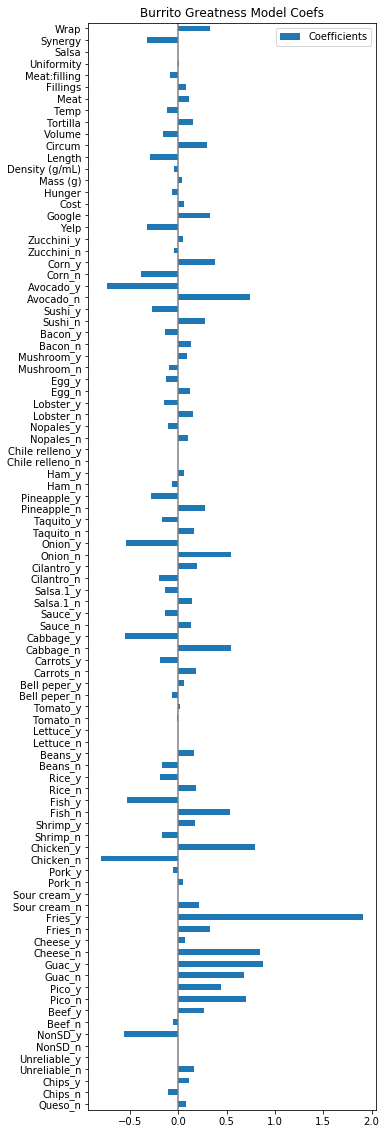

In [12]:
# First we have to extract the feature names that were created by our encoder
feature_names = (clf.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .named_steps['onehot']
                      .get_feature_names(input_features=categorical_cols))

# Now that we have the categorical names, we can add them back into the numerical names
feature_names = np.concatenate(
    [feature_names, numerical_cols])

coefs = pd.DataFrame(
    clf.named_steps['classifier'].coef_[0],
    columns=['Coefficients'], index=feature_names
)

coefs.plot(kind='barh', figsize=(20, 20))
plt.title('Burrito Greatness Model Coefs')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.7)

<b>By observing the visualization above, we can see how each feature is influencing the model. It looks like there is a positive relationship between fries and Great burritos</b>

### Get model's validation accuracy
Looks like our model actually outperforms the naive model

In [13]:
val_y = df_val["Great"]
pred = clf.predict(prepare_df(df_val).drop("Great", axis=1))
accuracy_score(val_y, pred)

0.8117647058823529

### Get your model's test accuracy
Now we can test it! We performed slightly worse on this data set, but it is still significantly better than the naive method.

In [14]:
test_y = df_test["Great"]
pred = clf.predict(prepare_df(df_test).drop("Great", axis=1))
accuracy_score(test_y, pred)

0.7894736842105263